# Описание задачи
Национальное обследование по здоровью и питанию (NHANES), проводимое Центрами по контролю и профилактике заболеваний (CDC), собирает обширную информацию о здоровье и питании разнообразного населения США. Датасет NHANES обычно слишком широк для конкретных аналитических целей. В данном поднаборе данных мы сужаем наш фокус на прогнозировании возраста участников, извлекая подмножество признаков из более крупного датасета NHANES. Эти выбранные признаки включают физиологические измерения, образ жизни и биохимические маркеры, которые, как предполагается, имеют сильную корреляцию с возрастом.

**Цель** - создать модель машинного обучения для прогнозирования возраста участников национального обследования по здоровью и питанию (NHANES) на основе предоставленных признаков.

**Метрика** - в качестве метрики будет использоваться accuracy - нам просто важно чтоб модель правильно относила людей к группе возраста по их характеристикам

**Задачи в данном ноутбуке** - провести EDA и получить 3 модели МО для сервиса.

In [118]:
import warnings
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import pickle
from sklearn.metrics import accuracy_score

In [42]:
warnings.filterwarnings('ignore')
SEED = 97
random.seed(SEED)

# EDA

In [30]:
df = pd.read_csv('./NHANES_age_prediction.csv', usecols=lambda column: column not in
                ['SEQN', 'RIDAGEYR'])

SEQN - порядковый номер респондента

age_group - таргет/возрастная группа

RIDAGEYR - возраст

RIAGENDR - гендер

PAQ605 - Активная трудовая деятельность

BMXBMI - индекс массы тела

DIQ010 - врач сказал, что у вас диабет

LBXGLU - уровень глюкозы натощак(Fasting Glucose)

LBXGLT - двухчасовой уровень глюкозы(Two Hour Glucose)

LBXIN - инсулин

In [32]:
df.head()

,age_group,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,Adult,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,Adult,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,Adult,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,Adult,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,Adult,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [33]:
df.describe()

,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age_group  2278 non-null   object 
 1   RIAGENDR   2278 non-null   float64
 2   PAQ605     2278 non-null   float64
 3   BMXBMI     2278 non-null   float64
 4   LBXGLU     2278 non-null   float64
 5   DIQ010     2278 non-null   float64
 6   LBXGLT     2278 non-null   float64
 7   LBXIN      2278 non-null   float64
dtypes: float64(7), object(1)
memory usage: 142.5+ KB


In [35]:
print(*df.columns, sep=', ')

age_group, RIAGENDR, PAQ605, BMXBMI, LBXGLU, DIQ010, LBXGLT, LBXIN


# Missings

In [18]:
df.isnull().sum().sum()

0

# Outliers

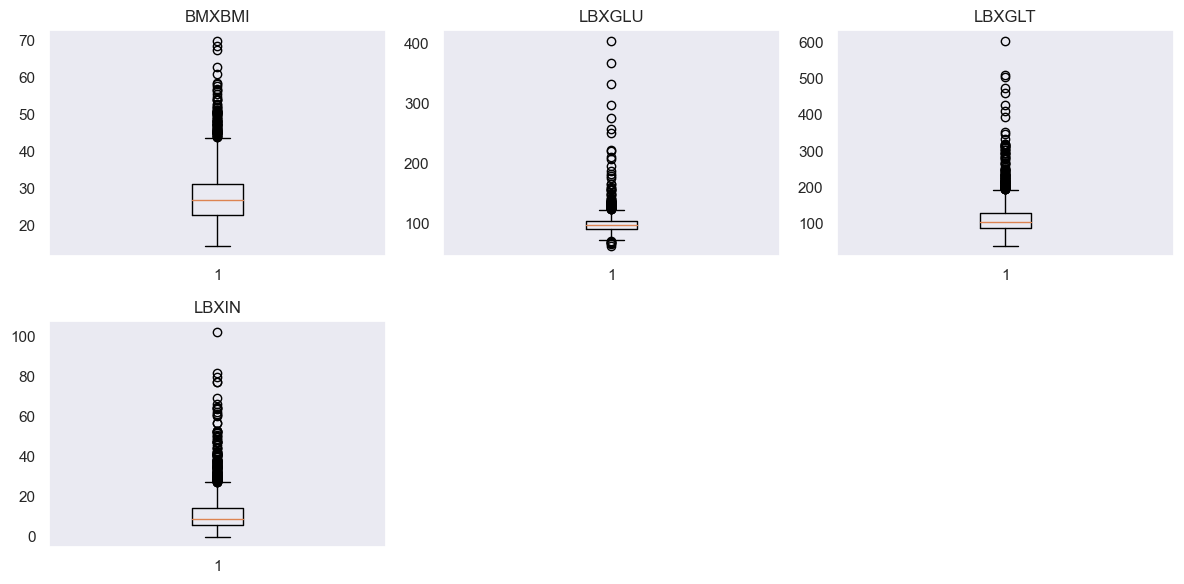

In [36]:
plt.figure(figsize=(12, 6))
numerical_columns = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [37]:
def remove_outliers_iqr(df, columns):
    df_no_outliers = df.copy()
    for column in columns:
        q1 = df_no_outliers[column].quantile(0.25)
        q3 = df_no_outliers[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
    return df_no_outliers


df = remove_outliers_iqr(df, numerical_columns)

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers using IQR: {df_without_outliers.shape}")

Original DataFrame shape: (1898, 8)
DataFrame shape after removing outliers using IQR: (1898, 8)


In [43]:
df['age_group'] = df['age_group'].replace({'Adult': 0, 'Senior': 1})

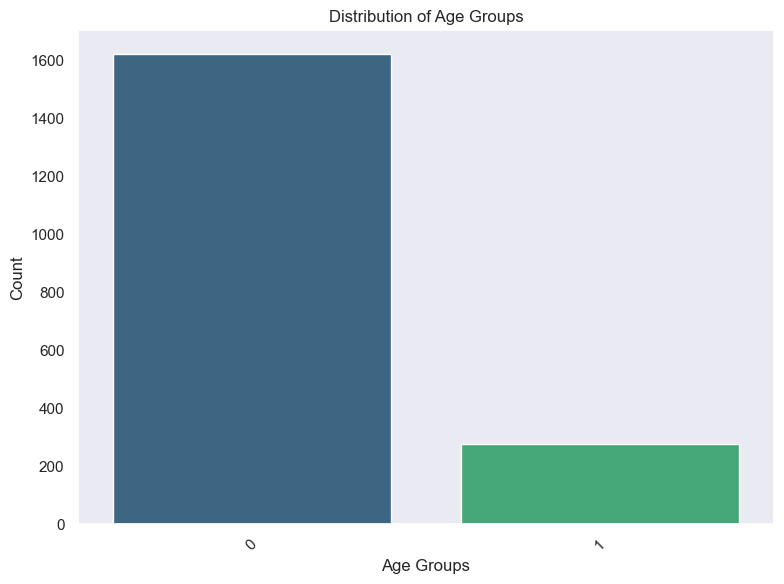

In [44]:
plt.figure(figsize=(8, 6))
sns.set(style="dark") 
sns.countplot(x='age_group', data=df, palette='viridis')  
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Выборка несбалансированная, учтем**

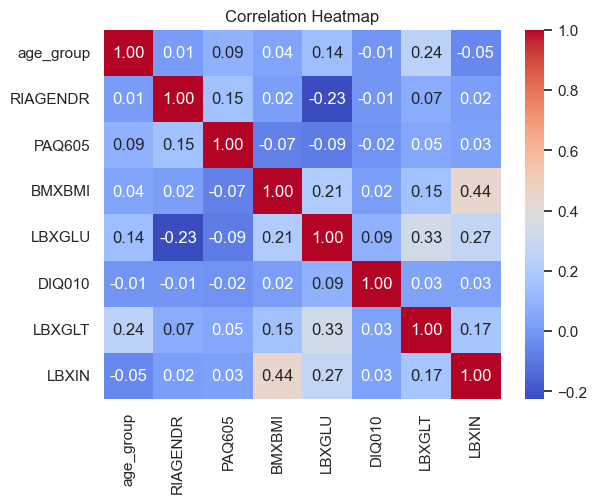

In [49]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1000x800 with 0 Axes>

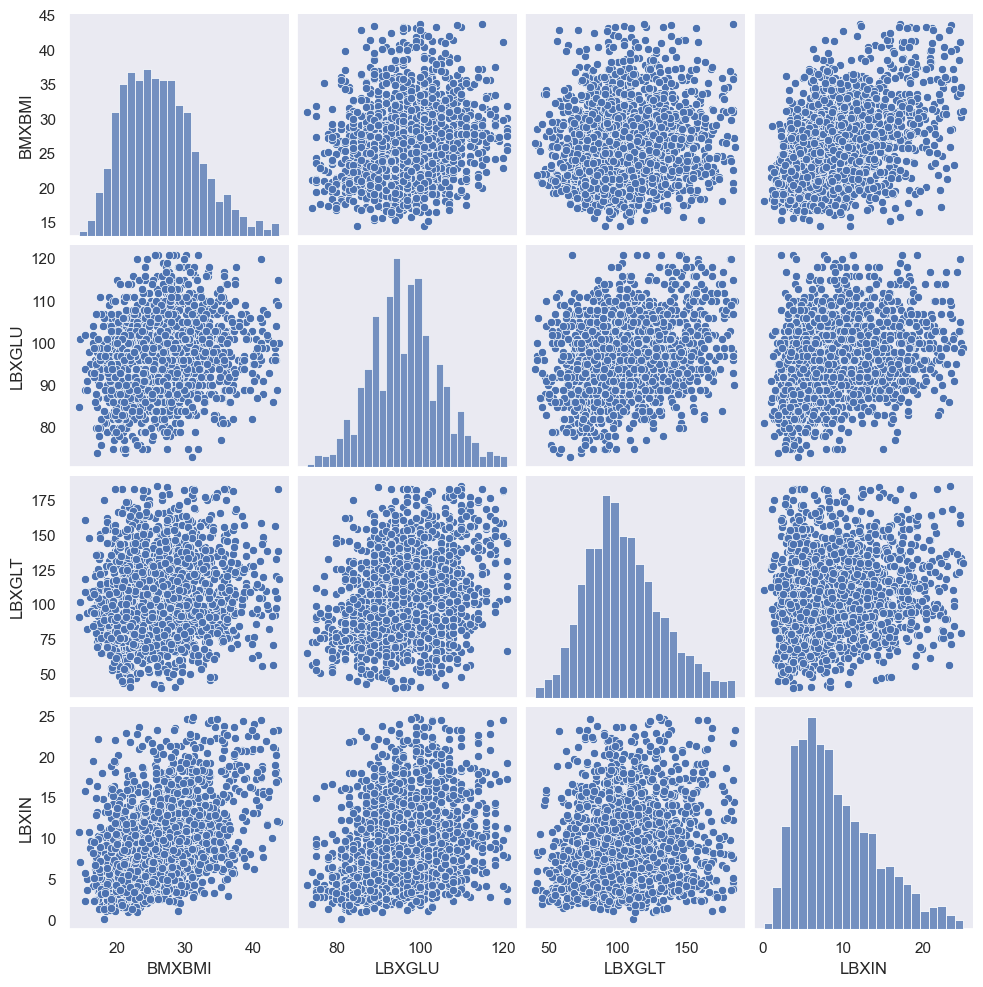

In [48]:
plt.figure(figsize=(10, 8))
sns.pairplot(df[['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']])
plt.show()

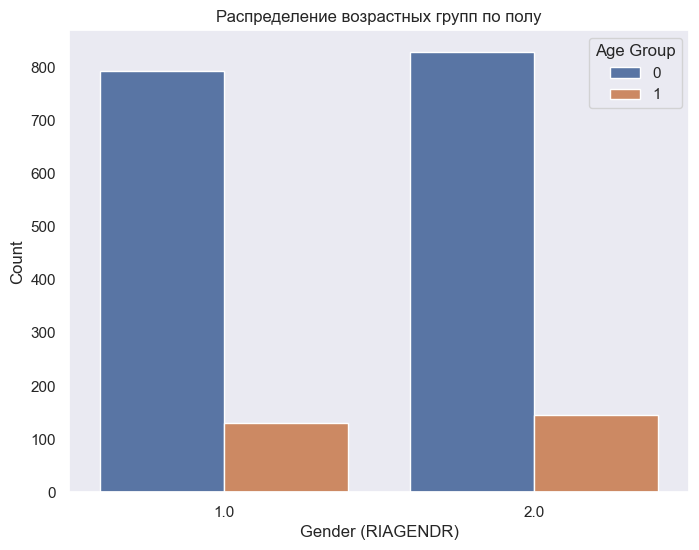

In [51]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RIAGENDR', hue='age_group', data=df)
plt.title('Распределение возрастных групп по полу')
plt.xlabel('Gender (RIAGENDR)')
plt.ylabel('Count')
plt.legend(title='Age Group')
plt.show()

# Modeling

In [103]:
X = df.drop(['age_group'], axis=1)
y = df['age_group']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['age_group'], axis=1), df['age_group'], stratify=df['age_group'], test_size=0.2, random_state=5)

In [73]:
num_folds = 5
random_state = 42
scoring = 'accuracy'

models = []

models.append(('LR', LogisticRegression()))
models.append(('StandardScaler + LR', Pipeline([('StandardScaler', StandardScaler()), ('LR', LogisticRegression())])))
models.append(('MinMaxScaler + LR', Pipeline([('MinMaxScaler', MinMaxScaler()), ('LR', LogisticRegression())])))

models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('StandardScaler + KNeighborsClassifier', Pipeline([('StandardScaler', StandardScaler()), ('KNeighborsClassifier', KNeighborsClassifier())])))
models.append(('MinMaxScaler + KNeighborsClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('KNeighborsClassifier', KNeighborsClassifier())])))

models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('StandardScaler + DecisionTreeClassifier', Pipeline([('StandardScaler', StandardScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier())])))
models.append(('MinMaxScaler + DecisionTreeClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('DecisionTreeClassifier', DecisionTreeClassifier())])))

models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('StandardScaler + RandomForestClassifier', Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier())])))
models.append(('MinMaxScaler + RandomForestClassifier', Pipeline([('MinMaxScaler', MinMaxScaler()), ('RandomForestClassifier', RandomForestClassifier())])))

models.append(('CatBoostClassifier', CatBoostClassifier(verbose=0)))

In [74]:
results = []
names = []
times = []

for name, model in models:
    start = time.time()
    kfold = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    end = time.time()
    times.append(end - start)
    
    print(name, round(cv_results.mean(),2), round(cv_results.std(),2), round(end - start,2), ' sec.')

LR 0.85 0.01 0.07  sec.
StandardScaler + LR 0.86 0.01 0.03  sec.
MinMaxScaler + LR 0.86 0.01 0.03  sec.
KNeighborsClassifier 0.83 0.01 0.05  sec.
StandardScaler + KNeighborsClassifier 0.85 0.01 0.07  sec.
MinMaxScaler + KNeighborsClassifier 0.85 0.02 0.06  sec.
DecisionTreeClassifier 0.77 0.02 0.04  sec.
StandardScaler + DecisionTreeClassifier 0.77 0.01 0.04  sec.
MinMaxScaler + DecisionTreeClassifier 0.77 0.02 0.04  sec.
RandomForestClassifier 0.85 0.01 1.24  sec.
StandardScaler + RandomForestClassifier 0.85 0.01 1.21  sec.
MinMaxScaler + RandomForestClassifier 0.85 0.02 1.2  sec.
CatBoostClassifier 0.85 0.01 7.29  sec.


In [83]:
result_df = pd.DataFrame(
    {'names': names,
     'score': [round(np.mean(i),3) for i in results],
     'time': [round(i,3) for i in times]
    })
result_df.sort_values(by='score', ascending=False)

,names,score,time
1,StandardScaler + LR,0.856,0.027
2,MinMaxScaler + LR,0.855,0.034
0,LR,0.854,0.074
9,RandomForestClassifier,0.854,1.242
10,StandardScaler + RandomForestClassifier,0.852,1.213
12,CatBoostClassifier,0.850,7.287
5,MinMaxScaler + KNeighborsClassifier,0.848,0.061
11,MinMaxScaler + RandomForestClassifier,0.848,1.204
4,StandardScaler + KNeighborsClassifier,0.847,0.067
3,KNeighborsClassifier,0.830,0.049


## Eval

In [114]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

models[1][1].fit(X_train_scaled, y_train)  
models[9][1].fit(X_train, y_train)  
models[12][1].fit(X_train, y_train) 

In [115]:
lg_pred = models[1][1].predict(X_test_scaled)
rf_pred = models[9][1].predict(X_test)
cb_pred = models[12][1].predict(X_test)

In [117]:
print('Аccuracy для модели 1: {0:0.4f}'. format(accuracy_score(y_test, lg_pred)))
print('Аccuracy для модели 2: {0:0.4f}'. format(accuracy_score(y_test, rf_pred)))
print('Аccuracy для модели 3: {0:0.4f}'. format(accuracy_score(y_test, cb_pred)))

Аccuracy для модели 1: 0.8553
Аccuracy для модели 2: 0.8474
Аccuracy для модели 3: 0.8342


## Saving 

In [120]:
pipe = Pipeline([('StandardScaler', StandardScaler()), ('LR', LogisticRegression())])
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)  

pipe.fit(X_scaled, y)

with open('models/lg.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [121]:
rf = RandomForestClassifier().fit(X, y)

with open('models/rf.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [122]:
cb = CatBoostClassifier(verbose=0).fit(X, y)

with open('models/cb.pkl', 'wb') as file:
    pickle.dump(cb, file)